## ERA5-Land monthly averaged data from 1950 to present 
https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=overview

### Focus in Madagascar 
```'area': [-9.95, 40.23, -26.8, 52.45]```

In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import numpy as np
from shared import *
import warnings

warnings.filterwarnings("ignore")

In [2]:
param_long_name = '10m_u_component_of_wind'
param_short_name = 'u10'

In [3]:
ds = xr.open_mfdataset(['data_0.nc', 'data_1.nc', 'data_2.nc'], chunks={'time': "auto"}, concat_dim="valid_time", combine='nested', parallel=False)

In [4]:
# Resample to monthly data (if necessary)
ds_sorted = ds.sortby('valid_time')
ds_monthly = ds_sorted.resample(valid_time='1ME').first()
ds_monthly['t2m_c'] = ds_monthly['t2m'] - 273.15
ds_monthly['skt_c'] = ds_monthly['skt'] - 273.15
ds_monthly['stl1_c'] = ds_monthly['stl1'] - 273.15
ds_monthly['stl2_c'] = ds_monthly['stl2'] - 273.15
ds_monthly['stl3_c'] = ds_monthly['stl3'] - 273.15
ds_monthly['stl4_c'] = ds_monthly['stl4'] - 273.15

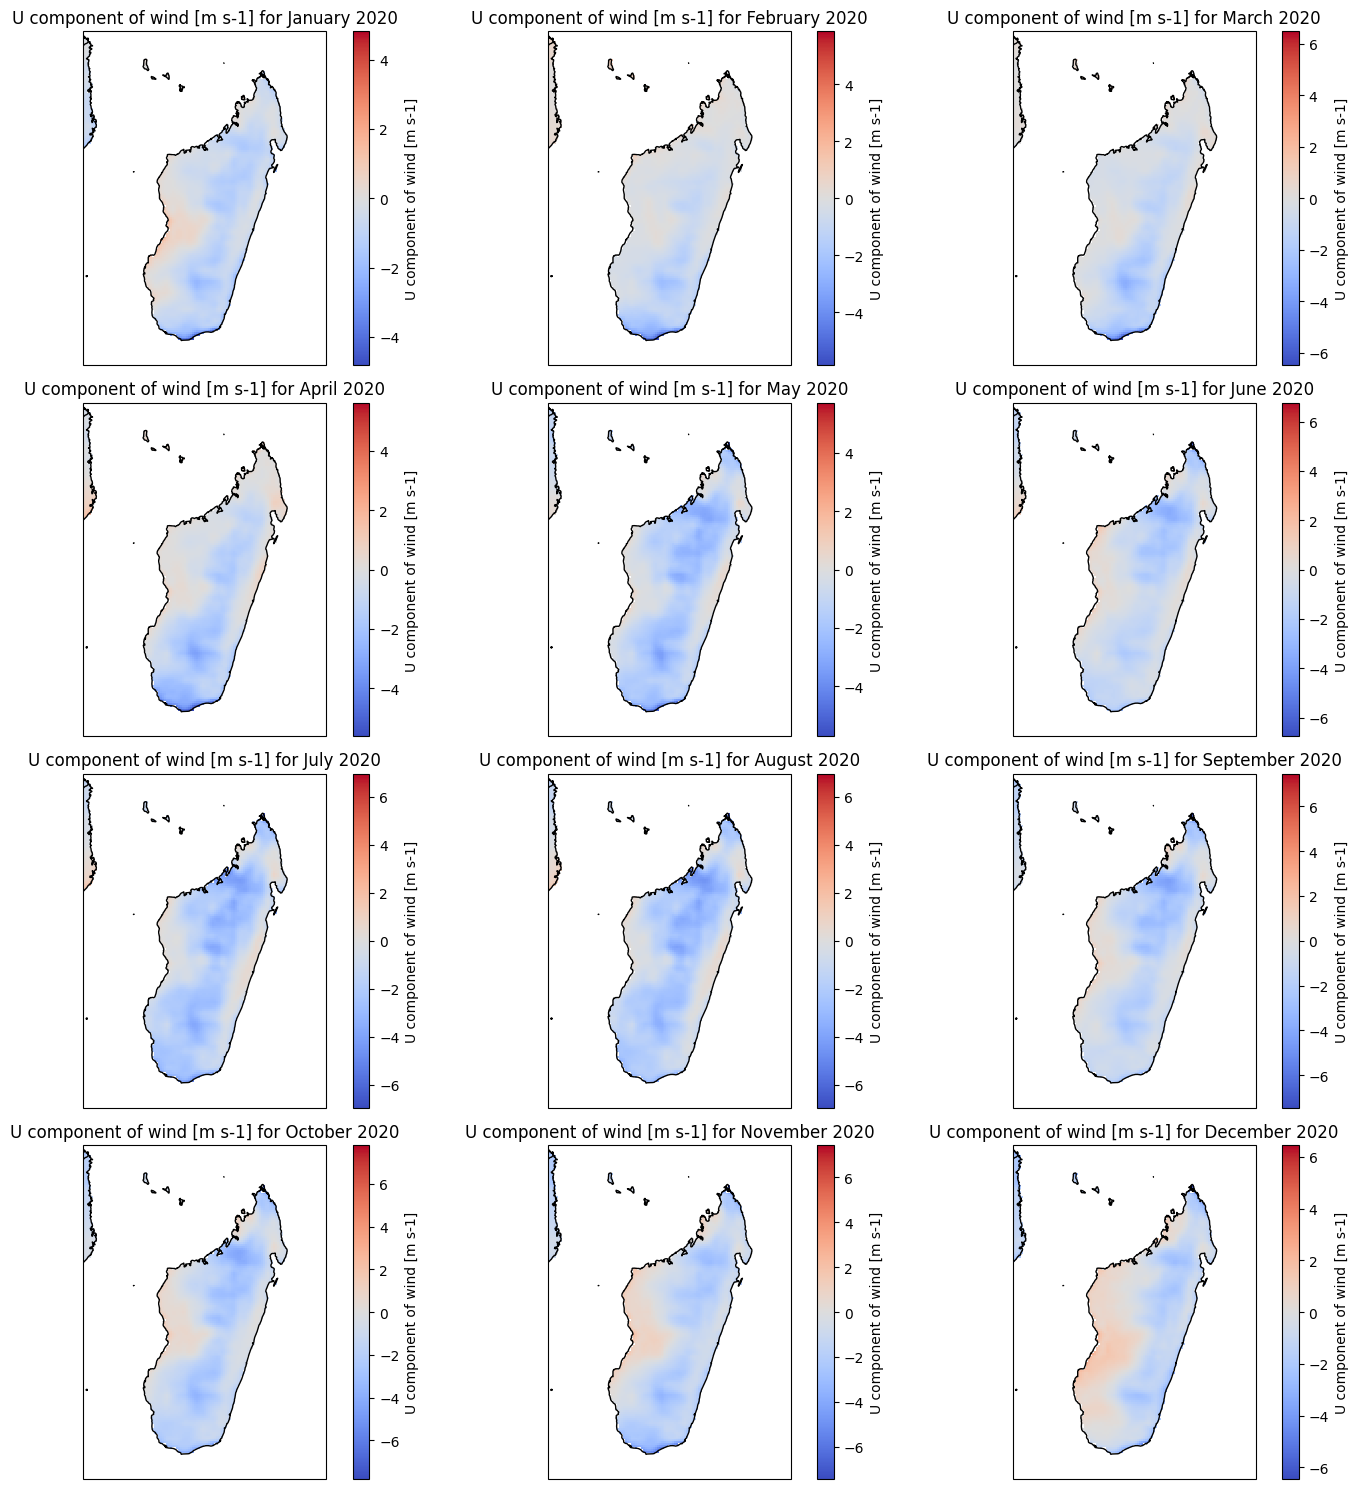

In [5]:
visualise_variable_annually(ds_monthly, param_long_name, 2020)

## Compare to baseline (1991 to 2023)

In [6]:
target_year = 2021
monthly_baseline = create_monthly_baseline(ds_monthly, ignore_years=[2019, 2020, 2021, 2022, 2023])
ds_target = ds_monthly.sel(valid_time=ds_monthly['valid_time'].dt.year == target_year)

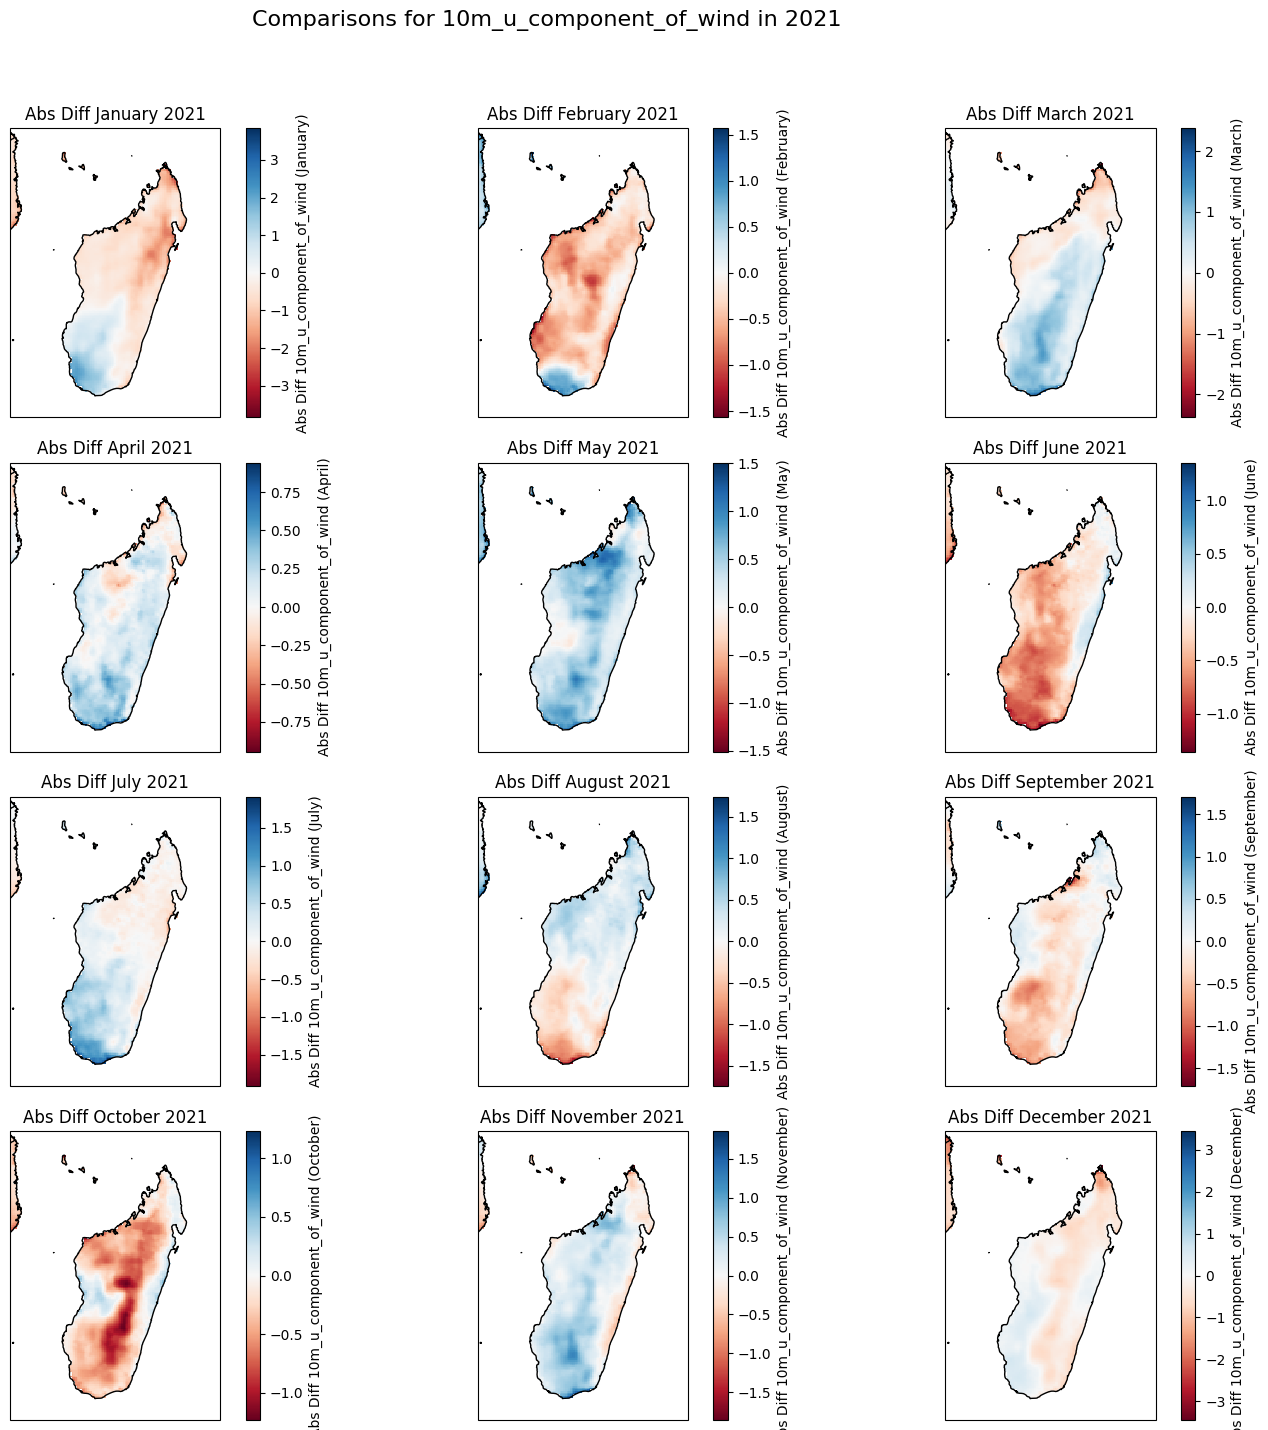

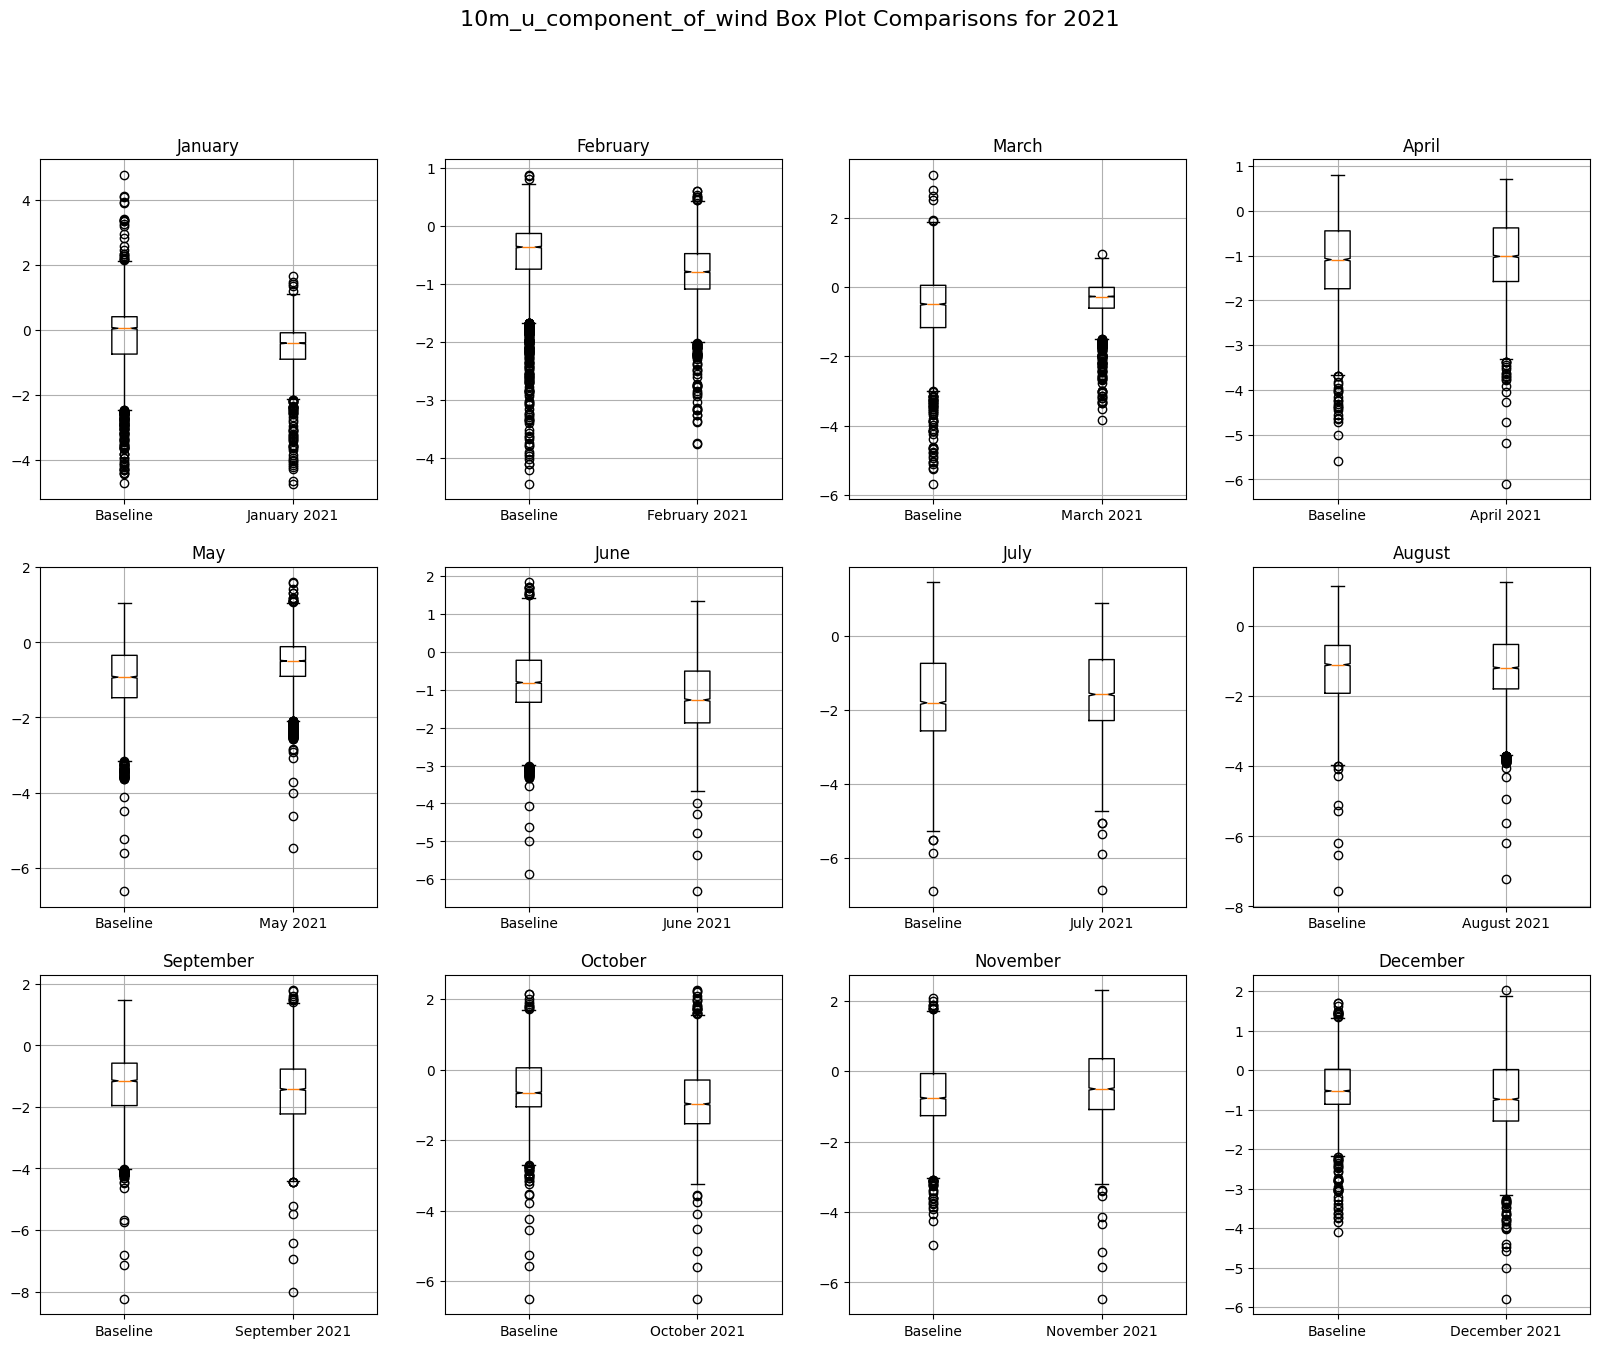

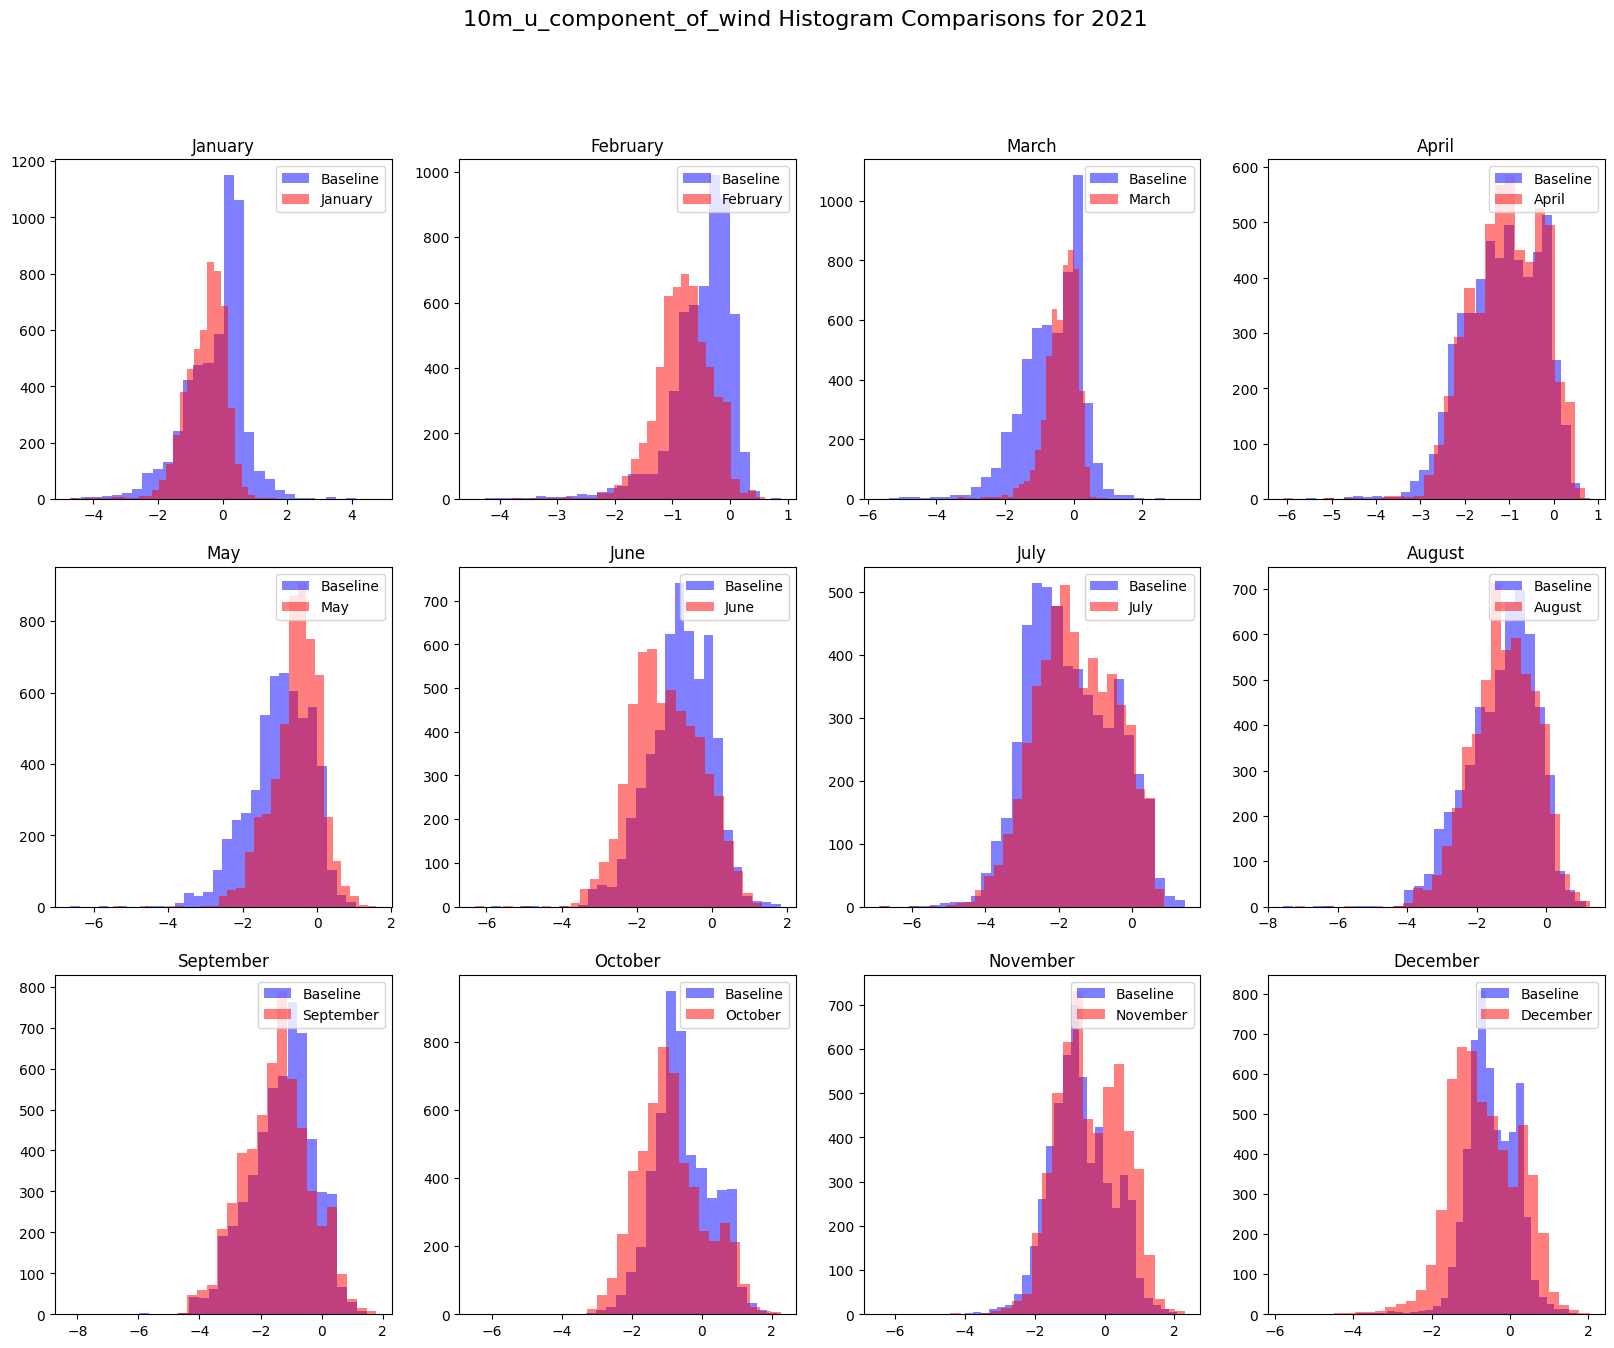

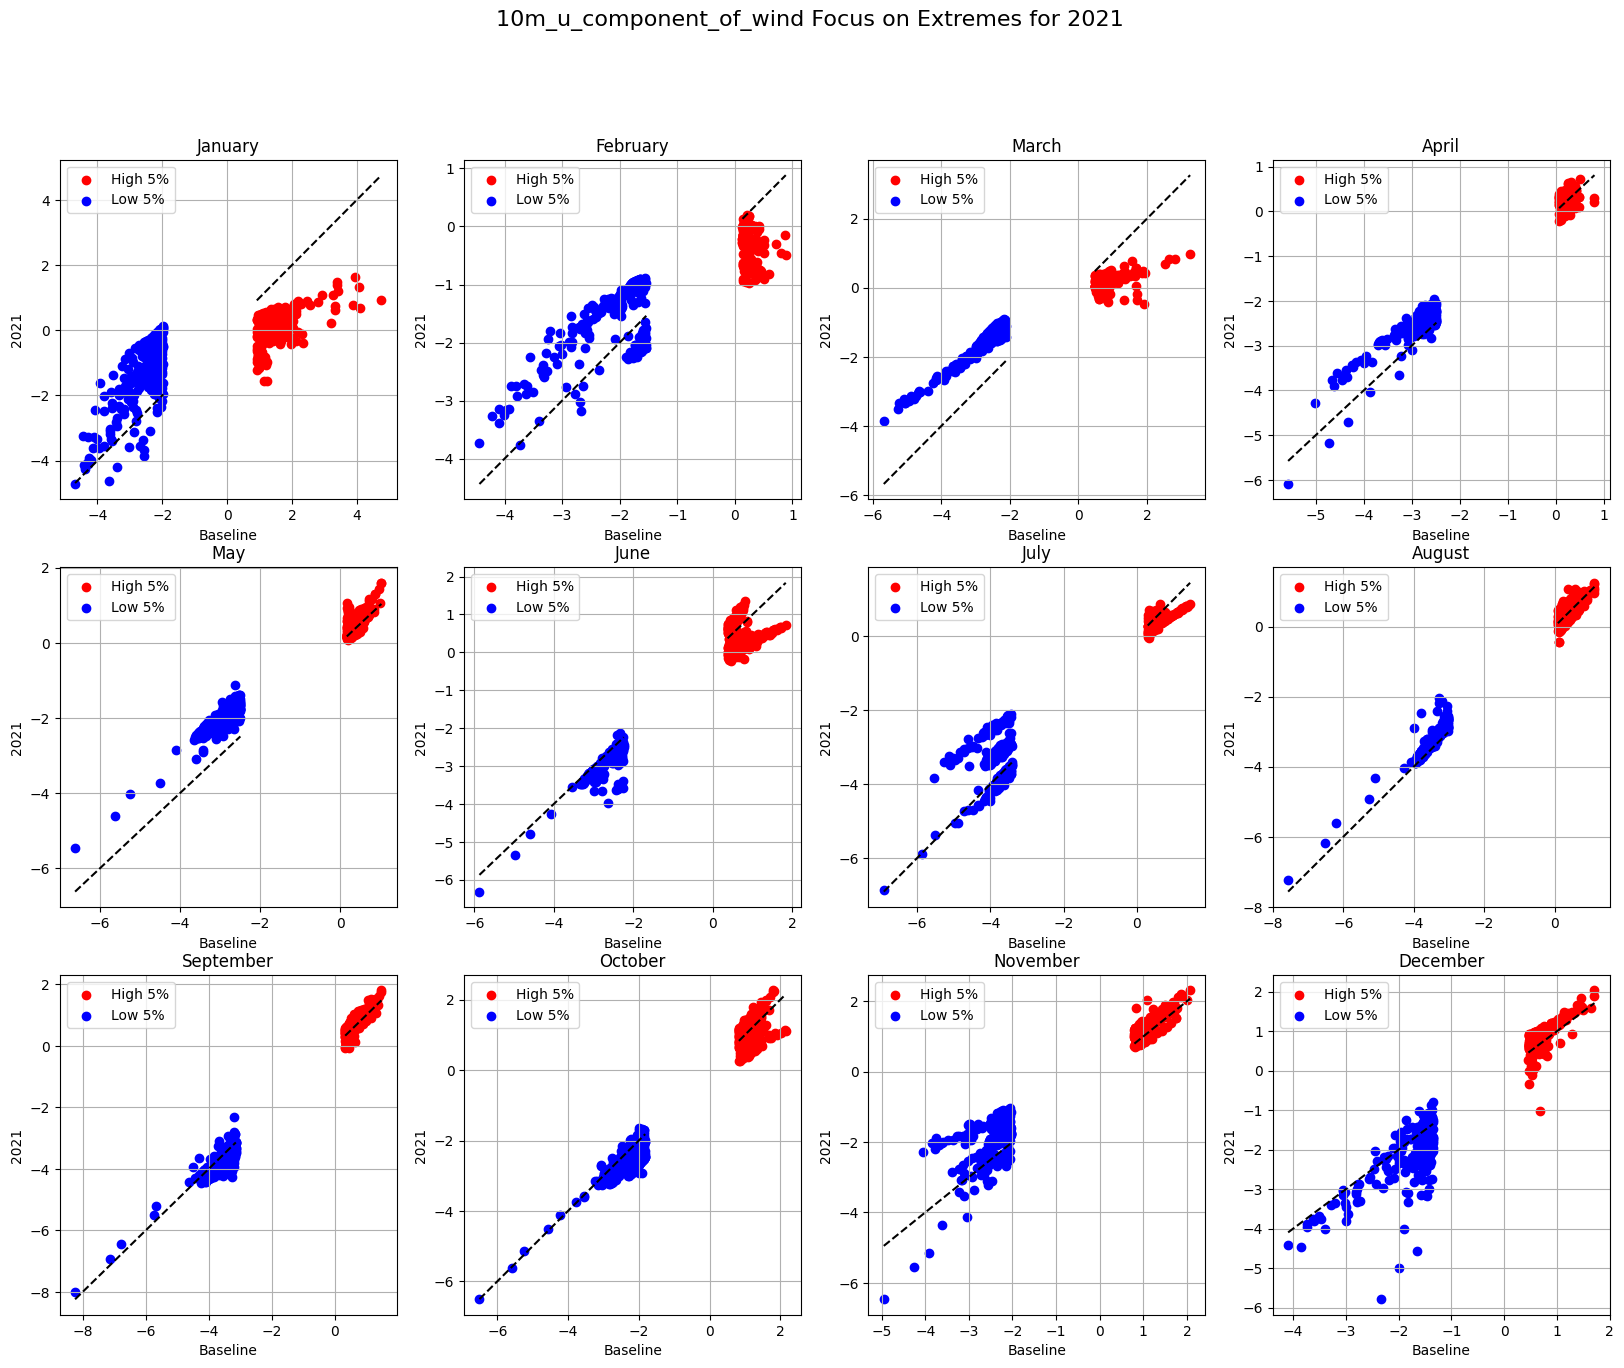

In [7]:
make_comparisons(ds_target, monthly_baseline, param_long_name, target_year, show_box_plots=True, show_hists=True, show_extremes_plot=True)

In [8]:
var_baseline = monthly_baseline[param_short_name]
ds_2020 = ds_monthly.sel(valid_time=ds_monthly['valid_time'].dt.year == 2020)
var_2020 = ds_2020.groupby('valid_time.month').mean(dim='valid_time')[param_short_name]

In [9]:
var_baseline_flatten = var_baseline.sel(month=12).to_numpy().flatten()
var_2020_flatten = var_2020.sel(month=12).to_numpy().flatten()
valid_data = ~np.isnan(var_baseline_flatten) * ~np.isnan(var_2020_flatten)
var_baseline_flatten_valid = var_baseline_flatten[valid_data]
var_2020_flatten_valid = var_2020_flatten[valid_data]
var_2020_flatten_valid

array([-1.05902   , -0.87884426, -0.9641714 , ..., -4.4639273 ,
       -4.7836294 , -5.2625113 ], dtype=float32)

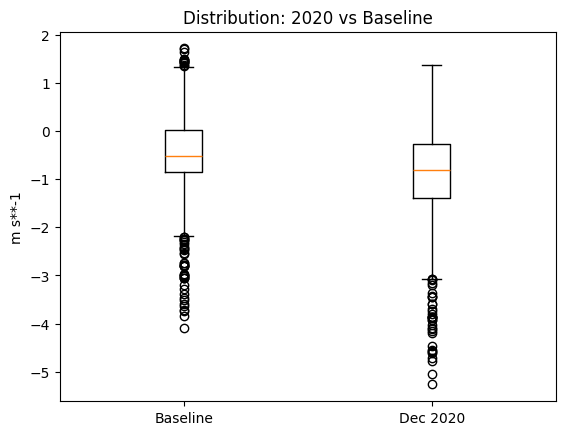

In [10]:
plt.boxplot([var_baseline_flatten_valid, var_2020_flatten_valid], labels=['Baseline', 'Dec 2020'])
plt.ylabel('m s**-1')
plt.title('Distribution: 2020 vs Baseline')
plt.show()

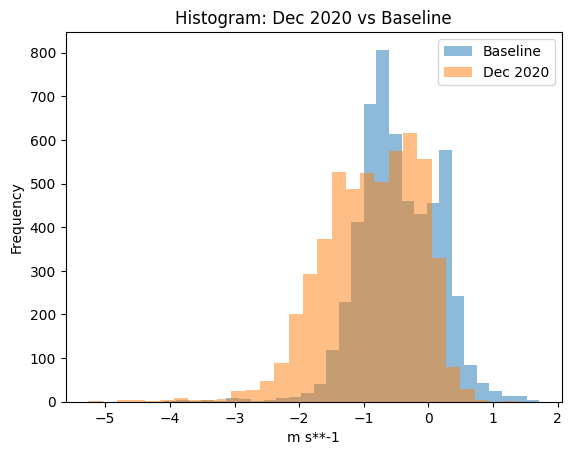

In [11]:
plt.hist(var_baseline_flatten_valid, bins=30, alpha=0.5, label='Baseline')
plt.hist(var_2020_flatten_valid, bins=30, alpha=0.5, label='Dec 2020')
plt.xlabel('m s**-1')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram: Dec 2020 vs Baseline')
plt.show()

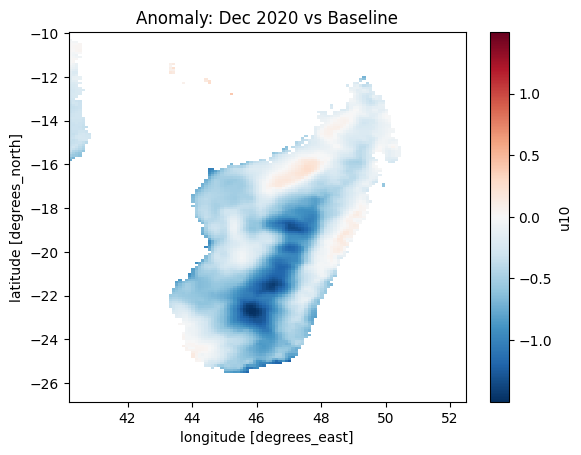

In [12]:
anomaly = (var_2020.sel(month=12) - var_baseline.sel(month=12))

# Plotting the anomaly with NaNs handled automatically
anomaly.plot(x='longitude', y='latitude', cmap='RdBu_r', center=0)
plt.title('Anomaly: Dec 2020 vs Baseline')
plt.show()

In [13]:
# Assuming ds_monthly and monthly_baseline are already defined

# Extract May 2020 and May baseline data
may_2020 = ds_monthly[param_short_name].sel(valid_time='2020-05', method='nearest')
may_baseline = monthly_baseline[param_short_name].sel(month=5)

# Compute the arrays to remove Dask dependency
may_2020_computed = may_2020.compute()
may_baseline_computed = may_baseline.compute()

# Flatten the data to sort and find the top/bottom 2% thresholds
flattened_may_2020 = may_2020_computed.values.flatten()

# Calculate the thresholds for the highest and lowest 2%
high_threshold = np.percentile(flattened_may_2020[np.isfinite(flattened_may_2020)], 98)
low_threshold = np.percentile(flattened_may_2020[np.isfinite(flattened_may_2020)], 2)

# Identify the pixels where the temperature is in the highest 2%
high_2_percent_mask = may_2020_computed >= high_threshold
low_2_percent_mask = may_2020_computed <= low_threshold

# Compute the masks to remove Dask dependency
high_2_percent_mask = high_2_percent_mask.compute()
low_2_percent_mask = low_2_percent_mask.compute()

# Extract the corresponding baseline values for the identified pixels
high_2_percent_baseline = may_baseline_computed.where(high_2_percent_mask, drop=True)
high_2_percent_2020 = may_2020_computed.where(high_2_percent_mask, drop=True)

low_2_percent_baseline = may_baseline_computed.where(low_2_percent_mask, drop=True)
low_2_percent_2020 = may_2020_computed.where(low_2_percent_mask, drop=True)

# Flatten the arrays and remove NaNs for scatter plot comparison
high_baseline_flat = high_2_percent_baseline.values.flatten()
high_2020_flat = high_2_percent_2020.values.flatten()

low_baseline_flat = low_2_percent_baseline.values.flatten()
low_2020_flat = low_2_percent_2020.values.flatten()

# Remove NaN values from both baseline and 2020 data
valid_high = np.isfinite(high_baseline_flat) & np.isfinite(high_2020_flat)
valid_low = np.isfinite(low_baseline_flat) & np.isfinite(low_2020_flat)

high_baseline_flat = high_baseline_flat[valid_high]
high_2020_flat = high_2020_flat[valid_high]

low_baseline_flat = low_baseline_flat[valid_low]
low_2020_flat = low_2020_flat[valid_low]

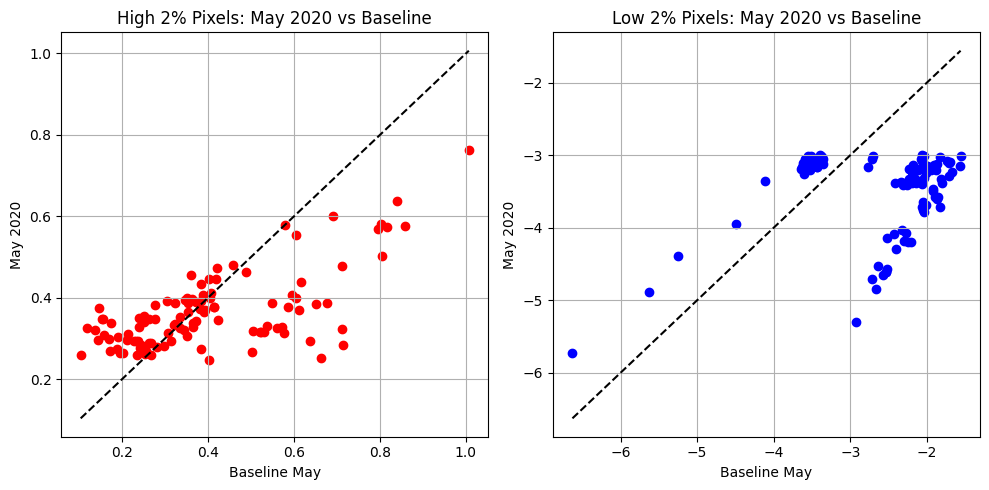

In [14]:
# Scatter plot for the high 2%
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(high_baseline_flat, high_2020_flat, color='red')
plt.plot([min(high_baseline_flat), max(high_baseline_flat)], 
         [min(high_baseline_flat), max(high_baseline_flat)], 'k--')
plt.xlabel('Baseline May')
plt.ylabel('May 2020')
plt.title('High 2% Pixels: May 2020 vs Baseline')
plt.grid(True)

# Scatter plot for the low 2%
plt.subplot(1, 2, 2)
plt.scatter(low_baseline_flat, low_2020_flat, color='blue')
plt.plot([min(low_baseline_flat), max(low_baseline_flat)], 
         [min(low_baseline_flat), max(low_baseline_flat)], 'k--')
plt.xlabel('Baseline May')
plt.ylabel('May 2020')
plt.title('Low 2% Pixels: May 2020 vs Baseline')
plt.grid(True)

plt.tight_layout()
plt.show()